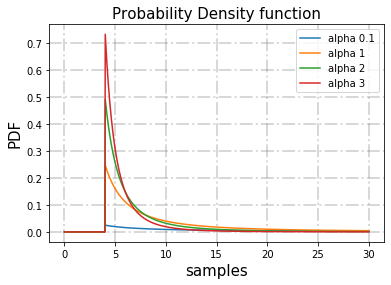

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pareto
x_m = 4 #scale
alpha = [0.1, 1, 2, 3] #list of values of shape parameters
samples = np.linspace(start=0, stop=30, num=1000)
for a in alpha:
    output = np.array([pareto.pdf(x=samples, b=a, loc=0, scale=x_m)])
    plt.plot(samples, output.T, label='alpha {0}' .format(a))
plt.xlabel('samples', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.title('Probability Density function', fontsize=15)
plt.grid(b=True, color='grey', alpha=0.3, linestyle='-.', linewidth=2)
plt.rcParams["figure.figsize"] = [5, 5]
plt.legend(loc='best')
plt.show()

41


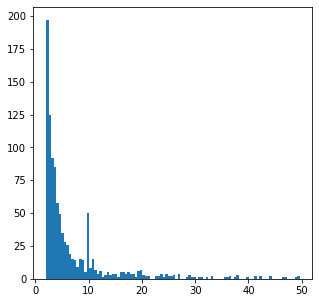

In [3]:
s = pareto.rvs(b=1, scale=2, size=1000)
print(len(s[s>50]))
s[s>50]=10
plt.hist(s, bins=100)
plt.show()

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pareto

def discretize_series(s, domain_size):
    n_invalid = len(s[s>=domain_size])
    s = s[s<domain_size]
    s = np.floor(s)
    new_s = np.random.randint(domain_size, size=n_invalid)
    s = np.concatenate((s, new_s))
    return np.random.permutation(s)
    
def data_generation(skew, domain_size, correlation, column_size, nrows=1000000):
    data = np.zeros((column_size, nrows))
    for i in range(column_size):
        if i == 0:
            s = np.random.randint(domain_size, size=nrows)
            data[i,:] = s
            continue
        s = pareto.rvs(b=skew, scale=1, size=nrows)
        s = discretize_series(s, domain_size)
        if i == 1:
            selected_cols = [0]
        else:
            num_selected_cols = max(np.random.randint(int(np.ceil(i*0.1))), 1)
            selected_cols = np.random.permutation(i)[0:num_selected_cols]
        idx = np.random.permutation(nrows)[0:int(nrows*correlation)]
        if len(idx) != 0:
            selected_data = data[selected_cols, :]
            selected_data = np.ceil(np.mean(selected_data, axis=0))
            s[idx] = selected_data[idx]
        assert len(np.unique(s)) <= domain_size, "invalid domain"
        data[i,:] = s
        
    data = pd.DataFrame(data=data.transpose(), columns=[f"attr{i}" for i in range(column_size)])
    return data

In [25]:
skew, domain_size, correlation, column_size = (1, 10, 0.5, 5)
data = data_generation(skew, domain_size, correlation, column_size, nrows=1000000)

In [26]:
import sys
sys.path.append('/home/ziniu.wzn/BayesCard')
from Models.Bayescard_BN import Bayescard_BN
BN = Bayescard_BN(f"toy_{skew}_{domain_size}_{correlation}_{column_size}")
BN.build_from_data(data)

Discretizing table takes 1.1055247783660889 secs
Structure learning took 15.1558678150177 secs.
done, parameter learning took 1.855208396911621 secs.


In [28]:
import torch
from torch import nn
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        self.layer_1 = nn.Linear(num_features, 256)
        self.layer_2 = nn.Linear(256, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_4 = nn.Linear(64, 32)
        self.layer_5 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)
    

In [29]:
from torch.utils.data import TensorDataset, DataLoader
X = np.random.randint(2, size=(1000, 213))
Y = np.sum(X, axis=1).reshape(-1,1) + np.random.randint(100, size=(1000,1))
tensor_x = torch.Tensor(X) 
tensor_y = torch.Tensor(Y)

my_dataset = TensorDataset(tensor_x, tensor_y) 
BATCH_SIZE = 64
train_loader = DataLoader(my_dataset, batch_size=BATCH_SIZE, shuffle=True) 

In [30]:
#check for gpu
import math
from torch import optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_FEATURES = 213
#Initialize the model, optimizer, and loss function. Transfer the model to GPU.
model = MultipleRegression(NUM_FEATURES)
model.to(device)
# def my_loss(output, target):
#     loss = torch.mean(torch.log10(output) - torch.log10(target))
#     return loss
criterion = nn.SmoothL1Loss()
#Model Params

EPOCHS =100
BATCH_SIZE = 64
LEARNING_RATE = 0.0002
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = 1e-6)
#dict of loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    "val": []
}
from tqdm.notebook import tqdm
#Start training 
print("Begin training.")
for e in range(1, EPOCHS+1):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        #print(X_train_batch.shape, y_train_batch.shape)
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        #train_loss = my_loss(y_train_pred, y_train_batch.unsqueeze(1))
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in train_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(train_loader))                              
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(train_loader):.5f}')


Begin training.
Epoch 001: | Train Loss: 156.29195 | Val Loss: 156.20263
Epoch 002: | Train Loss: 156.28192 | Val Loss: 156.19516
Epoch 003: | Train Loss: 156.21938 | Val Loss: 156.17925
Epoch 004: | Train Loss: 156.02718 | Val Loss: 155.63888
Epoch 005: | Train Loss: 154.79432 | Val Loss: 154.08869
Epoch 006: | Train Loss: 152.32252 | Val Loss: 149.68002
Epoch 007: | Train Loss: 145.40283 | Val Loss: 139.02746
Epoch 008: | Train Loss: 129.23853 | Val Loss: 115.21995
Epoch 009: | Train Loss: 94.87452 | Val Loss: 65.86224
Epoch 010: | Train Loss: 39.44769 | Val Loss: 28.42822
Epoch 011: | Train Loss: 28.76430 | Val Loss: 26.41133
Epoch 012: | Train Loss: 26.87219 | Val Loss: 26.74851
Epoch 013: | Train Loss: 26.40722 | Val Loss: 26.61437
Epoch 014: | Train Loss: 26.30776 | Val Loss: 26.44444
Epoch 015: | Train Loss: 26.42312 | Val Loss: 26.37300
Epoch 016: | Train Loss: 26.45944 | Val Loss: 26.46723
Epoch 017: | Train Loss: 26.36918 | Val Loss: 26.40512
Epoch 018: | Train Loss: 26.49786